# Phase 2: Data Cleaning Pipeline
## Multi-Campus Education Data Preprocessing

This notebook performs comprehensive data cleaning including:
1. Missing Data Detection and Treatment
2. Duplicate Detection and Removal
3. Outlier Detection and Treatment
4. Inconsistent Format Standardization
5. Noisy Data Cleaning

## Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load combined datasets from Phase 1
students_df = pd.read_csv('Outputs/raw_students_combined.csv')
courses_df = pd.read_csv('Outputs/raw_courses_combined.csv')
assessments_df = pd.read_csv('Outputs/raw_assessments_combined.csv')

print(f"Students: {students_df.shape}")
print(f"Courses: {courses_df.shape}")
print(f"Assessments: {assessments_df.shape}")

Students: (4635, 13)
Courses: (24652, 11)
Assessments: (75401, 13)


## Step 2: Missing Data Detection and Visualization

In [3]:
# Function to visualize missing data
def visualize_missing_data(df, title):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    if len(missing_counts) > 0:
        fig, ax = plt.subplots(figsize=(8, 4))
        bars = ax.barh(range(len(missing_counts)), missing_counts.values, color='coral')
        ax.set_yticks(range(len(missing_counts)))
        ax.set_yticklabels(missing_counts.index)
        ax.set_xlabel('Number of Missing Values')
        ax.set_title(f'Missing Values in {title}')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nMissing Value Summary for {title}:")
        for col, count in missing_counts.items():
            pct = (count / len(df)) * 100
            print(f"  {col}: {count} ({pct:.2f}%)")
    else:
        print(f"No missing values in {title}!")
    
    return missing_counts

MISSING DATA ANALYSIS - BEFORE CLEANING


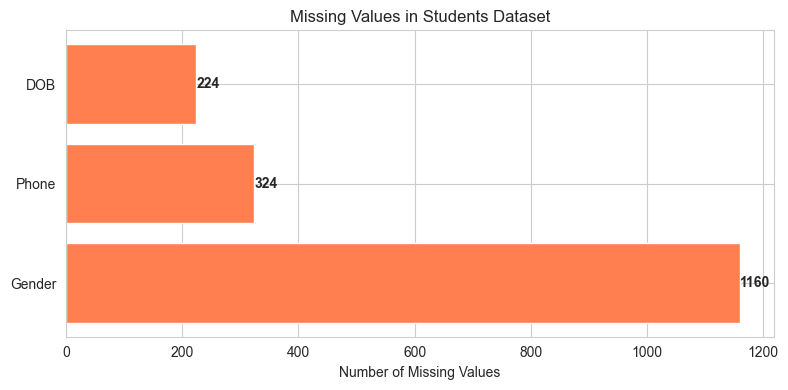


Missing Value Summary for Students Dataset:
  Gender: 1160 (25.03%)
  Phone: 324 (6.99%)
  DOB: 224 (4.83%)


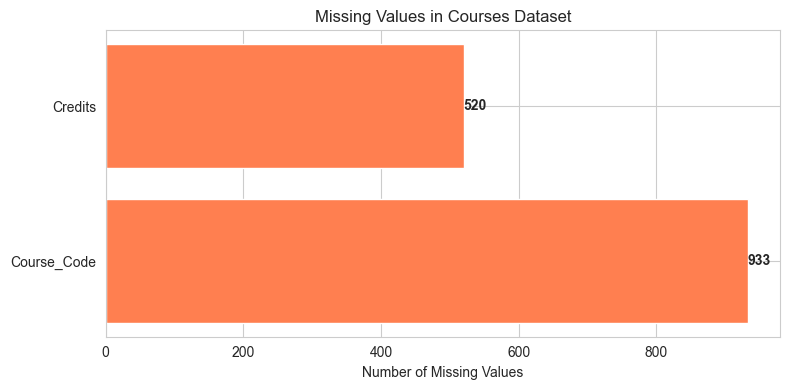


Missing Value Summary for Courses Dataset:
  Course_Code: 933 (3.78%)
  Credits: 520 (2.11%)


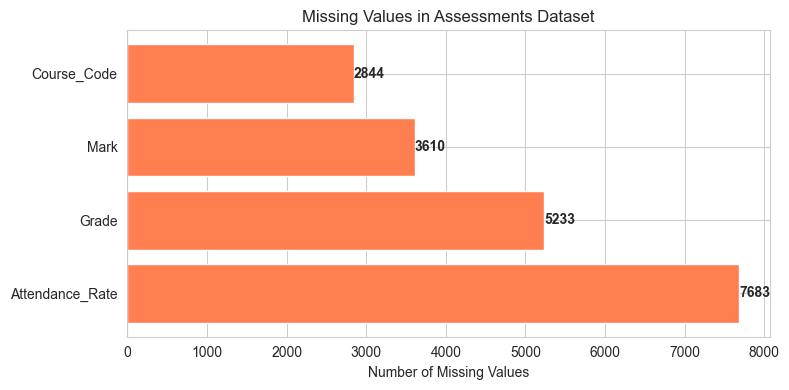


Missing Value Summary for Assessments Dataset:
  Attendance_Rate: 7683 (10.19%)
  Grade: 5233 (6.94%)
  Mark: 3610 (4.79%)
  Course_Code: 2844 (3.77%)


In [4]:
# Visualize missing data BEFORE cleaning
print("="*70)
print("MISSING DATA ANALYSIS - BEFORE CLEANING")
print("="*70)

students_missing_before = visualize_missing_data(students_df, 'Students Dataset')
courses_missing_before = visualize_missing_data(courses_df, 'Courses Dataset')
assessments_missing_before = visualize_missing_data(assessments_df, 'Assessments Dataset')

## Step 3: Missing Data Treatment

In [5]:
# Create copies for cleaning
students_clean = students_df.copy()
courses_clean = courses_df.copy()
assessments_clean = assessments_df.copy()

print("Created working copies of datasets for cleaning")

Created working copies of datasets for cleaning


In [6]:
# STUDENTS: Handle missing values
print("Handling missing values in Students dataset...\n")

# Gender: Fill with mode (most common value)
if students_clean['Gender'].isnull().sum() > 0:
    # First standardize existing values, then get mode
    gender_mode = students_clean['Gender'].mode()[0] if len(students_clean['Gender'].mode()) > 0 else 'Unknown'
    students_clean['Gender'].fillna('Unknown', inplace=True)
    print(f" Filled {students_missing_before.get('Gender', 0)} missing Gender values with 'Unknown'")

# DOB: Fill with median birth year or drop if too many missing
students_clean['DOB'] = pd.to_datetime(students_clean['DOB'], errors='coerce')

dob_missing = students_clean['DOB'].isnull().sum()

if dob_missing > 0:
    if dob_missing / len(students_clean) < 0.1:
        students_clean['DOB'] = students_clean['DOB'].fillna(
            pd.to_datetime('2000-01-01')
        )
        print(f" Filled {dob_missing} missing DOB values with default date '2000-01-01'")
    else:
        print(f" {dob_missing} missing DOB values retained (will handle in validation)")

# REMOVE TIME PART (keep only date)
students_clean['DOB'] = students_clean['DOB'].dt.date

# Phone: Keep as missing (not critical for analysis)
phone_missing = students_clean['Phone'].isnull().sum()
if phone_missing > 0:
    print(f" Retained {phone_missing} missing Phone values (non-critical field)")

print(f"\nStudents dataset: {students_df.shape} → {students_clean.shape}")

Handling missing values in Students dataset...

 Filled 1160 missing Gender values with 'Unknown'
 Filled 224 missing DOB values with default date '2000-01-01'
 Retained 324 missing Phone values (non-critical field)

Students dataset: (4635, 13) → (4635, 13)


In [7]:
# COURSES: Handle missing values
print("\nHandling missing values in Courses dataset...\n")

# Course_Code: Drop rows with missing course codes (critical field)
course_code_missing = courses_clean['Course_Code'].isnull().sum()
if course_code_missing > 0:
    courses_clean = courses_clean.dropna(subset=['Course_Code'])
    print(f" Dropped {course_code_missing} rows with missing Course_Code")

# Credits: Fill with median credits
credits_missing = courses_clean['Credits'].isnull().sum()
if credits_missing > 0:
    median_credits = courses_clean['Credits'].median()
    courses_clean['Credits'] = courses_clean['Credits'].fillna(median_credits, inplace=True)
    # courses_clean['Credits'] = courses_clean['Credits'].fillna(median_credits)
    print(f" Filled {credits_missing} missing Credits values with median ({median_credits})")

print(f"\nCourses dataset: {courses_df.shape} → {courses_clean.shape}")


Handling missing values in Courses dataset...

 Dropped 933 rows with missing Course_Code
 Filled 500 missing Credits values with median (4.0)

Courses dataset: (24652, 11) → (23719, 11)


In [8]:
# ASSESSMENTS: Handle missing values
print("\nHandling missing values in Assessments dataset...\n")

# Course_Code: Drop rows with missing course codes
assessment_code_missing = assessments_clean['Course_Code'].isnull().sum()
if assessment_code_missing > 0:
    assessments_clean = assessments_clean.dropna(subset=['Course_Code'])
    print(f" Dropped {assessment_code_missing} rows with missing Course_Code")

# Mark: Will handle after outlier treatment
mark_missing = assessments_clean['Mark'].isnull().sum()

if mark_missing > 0:
    median_mark = assessments_clean['Mark'].median()
    assessments_clean['Mark'] = assessments_clean['Mark'].fillna(median_mark)
    
    print(f" Filled {mark_missing} missing Mark values with median ({median_mark:.2f}) (will impute after outlier treatment)")
else:
    print(" No missing Mark values found.")

# Attendance_Rate: Fill with mean attendance
attendance_missing = assessments_clean['Attendance_Rate'].isnull().sum()
if attendance_missing > 0:
    mean_attendance = assessments_clean['Attendance_Rate'].mean()
    assessments_clean['Attendance_Rate'] = assessments_clean['Attendance_Rate'].fillna(mean_attendance, inplace=True)
    # assessments_clean['Attendance_Rate'] = assessments_clean['Attendance_Rate'].fillna(mean_attendance)
    print(f" Filled {attendance_missing} missing Attendance_Rate values with mean ({mean_attendance:.2f})")

print(f"\nAssessments dataset: {assessments_df.shape} → {assessments_clean.shape}")


Handling missing values in Assessments dataset...

 Dropped 2844 rows with missing Course_Code
 Filled 3485 missing Mark values with median (62.70) (will impute after outlier treatment)
 Filled 7410 missing Attendance_Rate values with mean (80.01)

Assessments dataset: (75401, 13) → (72557, 13)


## Step 4: Duplicate Detection and Removal

In [9]:
print("="*70)
print("DUPLICATE DETECTION AND REMOVAL")
print("="*70)

# STUDENTS: Remove duplicate Student_IDs (keep latest upload)
print("\n--- Students Dataset ---")
students_dup_count = students_clean['Student_ID'].duplicated().sum()
print(f"Duplicate Student IDs found: {students_dup_count}")

if students_dup_count > 0:
    # Sort by Upload_Date and keep the latest
    students_clean['Upload_Date'] = pd.to_datetime(students_clean['Upload_Date'])
    students_clean = students_clean.sort_values('Upload_Date', ascending=False)
    students_clean = students_clean.drop_duplicates(subset=['Student_ID'], keep='first')
    print(f" Removed {students_dup_count} duplicate students (kept latest upload)")

print(f"Students after deduplication: {len(students_clean)} records")

DUPLICATE DETECTION AND REMOVAL

--- Students Dataset ---
Duplicate Student IDs found: 135
 Removed 135 duplicate students (kept latest upload)
Students after deduplication: 4500 records


In [10]:
# COURSES: Remove duplicate enrollments
print("\n--- Courses Dataset ---")
courses_dup_count = courses_clean.duplicated(
    subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester']
).sum()
print(f"Duplicate enrollments found: {courses_dup_count}")

if courses_dup_count > 0:
    courses_clean = courses_clean.drop_duplicates(
        subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'],
        keep='first'
    )
    print(f" Removed {courses_dup_count} duplicate enrollments")

print(f"Courses after deduplication: {len(courses_clean)} records")


--- Courses Dataset ---
Duplicate enrollments found: 0
Courses after deduplication: 23719 records


In [11]:
# ASSESSMENTS: Remove duplicate assessment records
print("\n--- Assessments Dataset ---")
assessments_dup_count = assessments_clean.duplicated(
    subset=['Student_ID', 'Course_Code', 'Assessment_Type', 'Academic_Year', 'Semester']
).sum()
print(f"Duplicate assessments found: {assessments_dup_count}")

if assessments_dup_count > 0:
    # Keep the record with non-null mark if available, otherwise keep first
    assessments_clean = assessments_clean.sort_values('Mark', ascending=False, na_position='last')
    assessments_clean = assessments_clean.drop_duplicates(
        subset=['Student_ID', 'Course_Code', 'Assessment_Type', 'Academic_Year', 'Semester'],
        keep='first'
    )
    print(f" Removed {assessments_dup_count} duplicate assessments (kept highest mark)")

print(f"Assessments after deduplication: {len(assessments_clean)} records")


--- Assessments Dataset ---
Duplicate assessments found: 15661
 Removed 15661 duplicate assessments (kept highest mark)
Assessments after deduplication: 56896 records


## Step 5: Outlier Detection and Treatment

OUTLIER DETECTION AND TREATMENT


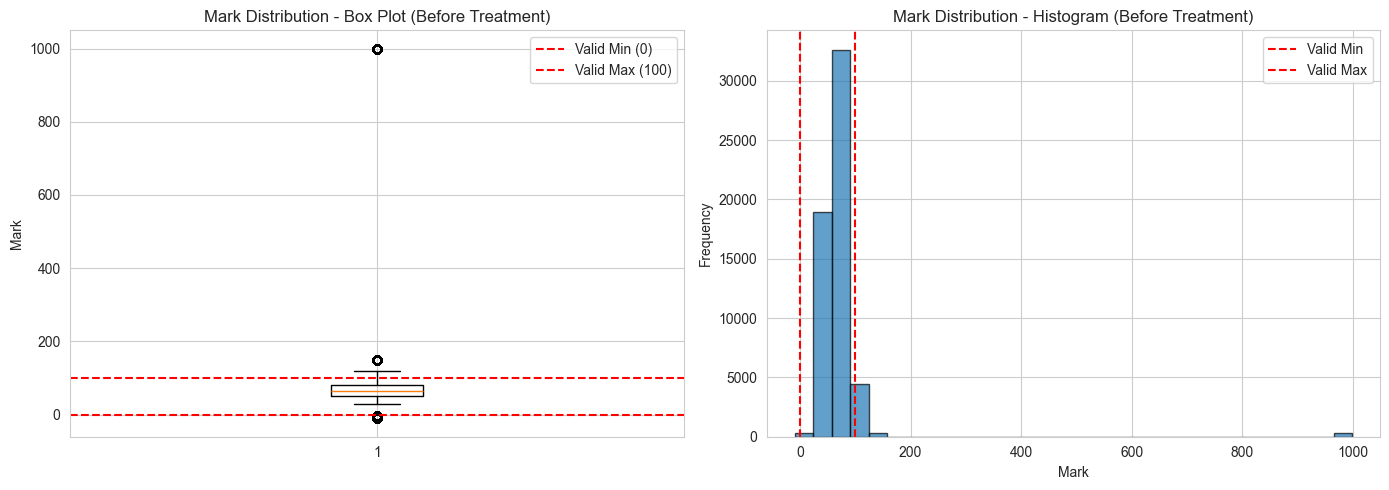


Mark Statistics (Before Treatment):
count    56896.000000
mean        70.081816
std         69.144794
min        -10.000000
25%         50.500000
50%         65.350000
75%         81.500000
max        999.000000
Name: Mark, dtype: float64


In [12]:
print("="*70)
print("OUTLIER DETECTION AND TREATMENT")
print("="*70)

# Visualize Mark distribution before treatment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(assessments_clean['Mark'].dropna(), vert=True)
axes[0].set_ylabel('Mark')
axes[0].set_title('Mark Distribution - Box Plot (Before Treatment)')
axes[0].axhline(y=0, color='r', linestyle='--', label='Valid Min (0)')
axes[0].axhline(y=100, color='r', linestyle='--', label='Valid Max (100)')
axes[0].legend()

# Histogram
axes[1].hist(assessments_clean['Mark'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Mark')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mark Distribution - Histogram (Before Treatment)')
axes[1].axvline(x=0, color='r', linestyle='--', label='Valid Min')
axes[1].axvline(x=100, color='r', linestyle='--', label='Valid Max')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nMark Statistics (Before Treatment):")
print(assessments_clean['Mark'].describe())

In [13]:
# Detect and treat outliers in Mark
print("\n--- Treating Outliers in Mark ---")

# Count outliers
outliers_low = (assessments_clean['Mark'] < 0).sum()
outliers_high = (assessments_clean['Mark'] > 100).sum()
total_outliers = outliers_low + outliers_high

print(f"Outliers detected:")
print(f"  Marks < 0: {outliers_low}")
print(f"  Marks > 100: {outliers_high}")
print(f"  Total: {total_outliers}")

# Treatment: Set invalid marks to NaN
if total_outliers > 0:
    assessments_clean.loc[
        (assessments_clean['Mark'] < 0) | (assessments_clean['Mark'] > 100), 
        'Mark'
    ] = np.nan
    print(f"\n Set {total_outliers} outlier marks to NaN")
    print(f"  These will be imputed with median in the next step")


--- Treating Outliers in Mark ---
Outliers detected:
  Marks < 0: 354
  Marks > 100: 847
  Total: 1201

 Set 1201 outlier marks to NaN
  These will be imputed with median in the next step


In [14]:
# Impute missing marks (including those set to NaN from outliers)
# Count total missing AFTER outlier treatment
mark_missing_total = assessments_clean['Mark'].isnull().sum()

if mark_missing_total > 0:
    median_mark = assessments_clean['Mark'].median()
    
    # Use assignment instead of inplace (cleaner & safer)
    assessments_clean['Mark'] = assessments_clean['Mark'].fillna(median_mark)
    
    print(f"\n Imputed {mark_missing_total} missing marks with median ({median_mark:.2f})")
else:
    print("\n No missing marks to impute.")

# Verify no missing remains
print(" Remaining missing marks:", assessments_clean['Mark'].isnull().sum())

# Recalculate grades after mark imputation
def calculate_grade(mark):
    if mark >= 70:
        return 'A'
    elif mark >= 60:
        return 'B'
    elif mark >= 50:
        return 'C'
    elif mark >= 40:
        return 'D'
    else:
        return 'F'

assessments_clean['Grade'] = assessments_clean['Mark'].apply(calculate_grade)
print(" Recalculated grades based on cleaned marks")


 Imputed 1201 missing marks with median (65.00)
 Remaining missing marks: 0
 Recalculated grades based on cleaned marks


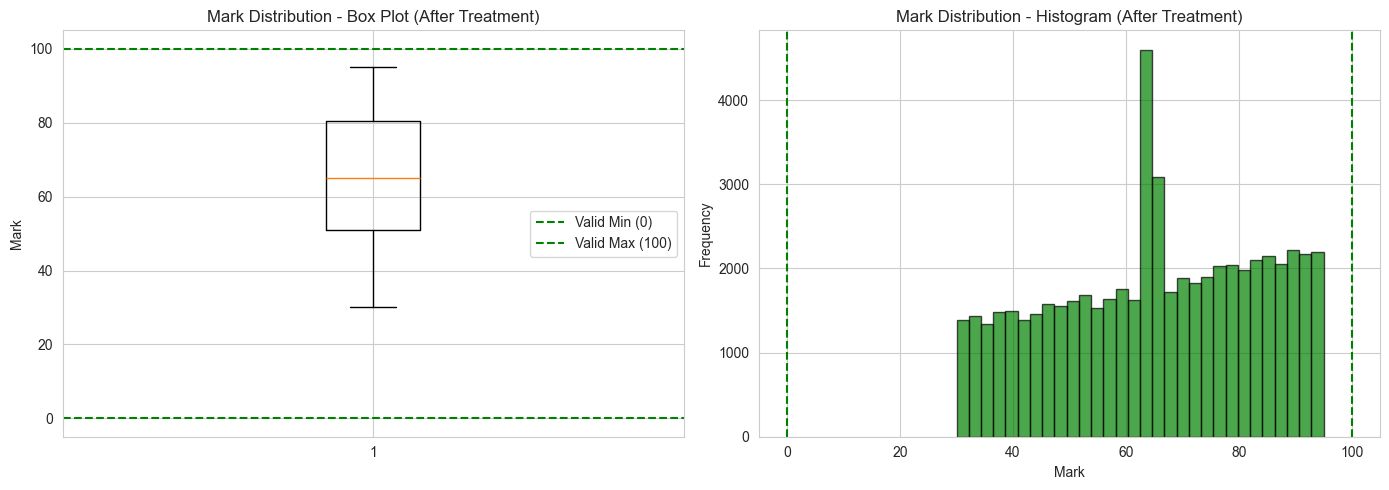


Mark Statistics (After Treatment):
count    56896.000000
mean        65.136512
std         17.993218
min         30.000000
25%         51.000000
50%         65.000000
75%         80.600000
max         95.000000
Name: Mark, dtype: float64


In [15]:
# Visualize Mark distribution after treatment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(assessments_clean['Mark'].dropna(), vert=True)
axes[0].set_ylabel('Mark')
axes[0].set_title('Mark Distribution - Box Plot (After Treatment)')
axes[0].axhline(y=0, color='g', linestyle='--', label='Valid Min (0)')
axes[0].axhline(y=100, color='g', linestyle='--', label='Valid Max (100)')
axes[0].legend()

# Histogram
axes[1].hist(assessments_clean['Mark'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Mark')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mark Distribution - Histogram (After Treatment)')
axes[1].axvline(x=0, color='g', linestyle='--')
axes[1].axvline(x=100, color='g', linestyle='--')

plt.tight_layout()
plt.show()

print("\nMark Statistics (After Treatment):")
print(assessments_clean['Mark'].describe())

## Step 6: Inconsistent Format Standardization

In [16]:
print("="*70)
print("STANDARDIZING INCONSISTENT FORMATS")
print("="*70)

# STUDENTS: Standardize formats
print("\n--- Students Dataset ---")

# Gender standardization
print("\nBefore Gender standardization:")
print(students_clean['Gender'].value_counts())

gender_mapping = {
    'M': 'Male', 'm': 'Male', 'Male': 'Male',
    'F': 'Female', 'f': 'Female', 'Female': 'Female'
}
students_clean['Gender'] = students_clean['Gender'].map(gender_mapping).fillna('Unknown')

print("\nAfter Gender standardization:")
print(students_clean['Gender'].value_counts())
print(" Gender values standardized")

STANDARDIZING INCONSISTENT FORMATS

--- Students Dataset ---

Before Gender standardization:
Gender
F         586
Female    576
f         572
M         569
Male      559
m         506
Name: count, dtype: int64

After Gender standardization:
Gender
Female     1734
Male       1634
Unknown    1132
Name: count, dtype: int64
 Gender values standardized


In [17]:
# Level standardization
print("\nBefore Level standardization:")
print(students_clean['Level'].value_counts())

level_mapping = {
    'L4': 'Level 4', 'Level 4': 'Level 4',
    'L5': 'Level 5', 'Level 5': 'Level 5',
    'L6': 'Level 6', 'Level 6': 'Level 6'
}
students_clean['Level'] = students_clean['Level'].map(level_mapping)

print("\nAfter Level standardization:")
print(students_clean['Level'].value_counts())
print(" Level values standardized")


Before Level standardization:
Level
L4         794
L6         752
L5         742
Level 5    742
Level 4    736
Level 6    734
Name: count, dtype: int64

After Level standardization:
Level
Level 4    1530
Level 6    1486
Level 5    1484
Name: count, dtype: int64
 Level values standardized


In [18]:
# Program name standardization (Title Case)
print("\nBefore Program standardization:")
print(students_clean['Program'].value_counts())

students_clean['Program'] = students_clean['Program'].str.title()

print("\nAfter Program standardization:")
print(students_clean['Program'].value_counts())
print(" Program names standardized to Title Case")


Before Program standardization:
Program
Mechanical Engineering    716
Information Technology    706
Civil Engineering         706
Software Engineering      696
Computer Science          673
Electronics               666
ELECTRONICS                65
INFORMATION TECHNOLOGY     65
CIVIL ENGINEERING          54
MECHANICAL ENGINEERING     54
COMPUTER SCIENCE           54
SOFTWARE ENGINEERING       45
Name: count, dtype: int64

After Program standardization:
Program
Information Technology    771
Mechanical Engineering    770
Civil Engineering         760
Software Engineering      741
Electronics               731
Computer Science          727
Name: count, dtype: int64
 Program names standardized to Title Case


In [19]:
# COURSES: Standardize formats
print("\n--- Courses Dataset ---")

# Course Code standardization (remove hyphens, uppercase)
print("\n Course Codes before standardization:")
print(courses_clean['Course_Code'].head(20).tolist())

courses_clean['Course_Code'] = courses_clean['Course_Code'].str.upper().str.replace('-', '', regex=False)

print("\n Course Codes after standardization:")
print(courses_clean['Course_Code'].head(20).tolist())
print("\n  Course codes standardized (uppercase, no hyphens)")


--- Courses Dataset ---

 Course Codes before standardization:
['CS202', 'PHY101', 'CS102', 'CS201', 'MTH101', 'CS-101', 'ENG101', 'ENG101', 'CS302', 'CS101', 'CS301', 'MTH102', 'cs302', 'PHY101', 'CS101', 'CS202', 'CS-201', 'CS202', 'MTH102', 'ENG101']

 Course Codes after standardization:
['CS202', 'PHY101', 'CS102', 'CS201', 'MTH101', 'CS101', 'ENG101', 'ENG101', 'CS302', 'CS101', 'CS301', 'MTH102', 'CS302', 'PHY101', 'CS101', 'CS202', 'CS201', 'CS202', 'MTH102', 'ENG101']

  Course codes standardized (uppercase, no hyphens)


In [20]:
# Semester standardization
print("\nBefore Semester standardization:")
print(courses_clean['Semester'].value_counts())

semester_mapping = {
    'S1': 'Semester 1', 'SEM1': 'Semester 1', 'Semester 1': 'Semester 1',
    'S2': 'Semester 2', 'SEM2': 'Semester 2', 'Semester 2': 'Semester 2'
}
courses_clean['Semester'] = courses_clean['Semester'].map(semester_mapping)

print("\nAfter Semester standardization:")
print(courses_clean['Semester'].value_counts())
print("\n  Semester values standardized")


Before Semester standardization:
Semester
Semester 1    4006
Semester 2    4003
S2            3986
SEM1          3954
S1            3919
SEM2          3851
Name: count, dtype: int64

After Semester standardization:
Semester
Semester 1    11879
Semester 2    11840
Name: count, dtype: int64

  Semester values standardized


In [21]:
# Date format standardization
print("\nStandardizing date formats...")

# Enrollment_Date
courses_clean['Enrollment_Date'] = pd.to_datetime(
    courses_clean['Enrollment_Date'], 
    errors='coerce'
).dt.strftime('%Y-%m-%d')
print("# Enrollment dates standardized to YYYY-MM-DD")


Standardizing date formats...
# Enrollment dates standardized to YYYY-MM-DD


In [22]:
# ASSESSMENTS: Standardize formats
print("\n--- Assessments Dataset ---")

# Course Code (same as courses)
assessments_clean['Course_Code'] = (
    assessments_clean['Course_Code']
    .str.upper()
    .str.replace('-', '', regex=False)
)
print("# Course codes standardized")

# Semester
assessments_clean['Semester'] = assessments_clean['Semester'].map(semester_mapping)
print("# Semester values standardized")

# Assessment Date - handle multiple formats
print("\nStandardizing Assessment dates...")

# Convert to datetime safely, coerce errors, and format as YYYY-MM-DD
assessments_clean['Assessment_Date'] = pd.to_datetime(
    assessments_clean['Assessment_Date'],
    errors='coerce',
    dayfirst=True 
)

date_missing = assessments_clean['Assessment_Date'].isnull().sum()
print("Missing dates before imputation:", date_missing)

if date_missing > 0:
    median_date = assessments_clean['Assessment_Date'].median()
    assessments_clean['Assessment_Date'] = assessments_clean['Assessment_Date'].fillna(median_date)
    print(f" Filled {date_missing} missing dates with median date ({median_date.date()})")
    
    assessments_clean['Assessment_Date'] = assessments_clean['Assessment_Date'].dt.date

print("# Assessment dates standardized to YYYY-MM-DD")


--- Assessments Dataset ---
# Course codes standardized
# Semester values standardized

Standardizing Assessment dates...
Missing dates before imputation: 49385
 Filled 49385 missing dates with median date (2025-09-12)
# Assessment dates standardized to YYYY-MM-DD


## Step 7: Noisy Data Cleaning

In [23]:
print("="*70)
print("CLEANING NOISY DATA")
print("="*70)

# STUDENTS: Clean names and text fields
print("\n--- Students Dataset ---")

# Count names with extra spaces
names_with_spaces = students_clean['Full_Name'].str.contains(r'^\s|\s$', regex=True, na=False).sum()
print(f"\nNames with leading/trailing spaces: {names_with_spaces}")

# Clean Full_Name: trim spaces, title case, remove extra spaces
students_clean['Full_Name'] = students_clean['Full_Name'].str.strip()
students_clean['Full_Name'] = students_clean['Full_Name'].str.replace(r'\s+', ' ', regex=True)
students_clean['Full_Name'] = students_clean['Full_Name'].str.title()
print("# Full names cleaned (trimmed, title case, no extra spaces)")

# Show sample cleaned names
print("\n Sample cleaned names:")
print(students_clean['Full_Name'].head(10).tolist())

CLEANING NOISY DATA

--- Students Dataset ---

Names with leading/trailing spaces: 472
# Full names cleaned (trimmed, title case, no extra spaces)

 Sample cleaned names:
['Marie Uwase', 'Emmanuel Kamanzi', 'Patrick Ntawukuriryayo', 'Beatrice Uwamahoro', 'Claude Nshimiyimana', 'Marie Mukamana', 'Jean Mutabazi', 'Beatrice Ntawukuriryayo', 'Joseph Niyibizi', 'Grace Iradukunda']


In [24]:
# Validate numeric fields
print("\n--- Validating Numeric Fields ---")

# Courses: Ensure Credits are positive
negative_credits = (courses_clean['Credits'] < 0).sum()
if negative_credits > 0:
    courses_clean.loc[courses_clean['Credits'] < 0, 'Credits'] = courses_clean['Credits'].median()
    print(f"# Fixed {negative_credits} negative credit values")
else:
    print("# All credits are positive")

# Assessments: Ensure Mark is within 0-100
invalid_marks = ((assessments_clean['Mark'] < 0) | (assessments_clean['Mark'] > 100)).sum()
if invalid_marks > 0:
    print(f" Found {invalid_marks} marks still outside 0-100 range (should be 0 after cleaning)")
else:
    print("# All marks are within valid range (0-100)")

# Assessments: Ensure Attendance_Rate is within 0-100
invalid_attendance = ((assessments_clean['Attendance_Rate'] < 0) | (assessments_clean['Attendance_Rate'] > 100)).sum()
if invalid_attendance > 0:
    assessments_clean.loc[
        (assessments_clean['Attendance_Rate'] < 0) | (assessments_clean['Attendance_Rate'] > 100),
        'Attendance_Rate'
    ] = assessments_clean['Attendance_Rate'].median()
    print(f"# Fixed {invalid_attendance} invalid attendance values")
else:
    print("# All attendance rates are within valid range (0-100)")


--- Validating Numeric Fields ---
# All credits are positive
# All marks are within valid range (0-100)
# All attendance rates are within valid range (0-100)


## Step 8: Before vs After Summary Report

In [25]:
print("="*70)
print("DATA CLEANING SUMMARY REPORT")
print("="*70)

# Create summary report
summary_data = {
    'Metric': [
        'Students Records',
        'Courses Records',
        'Assessments Records',
        'Missing Gender',
        'Missing DOB',
        'Missing Phone',
        'Missing Course_Code (Courses)',
        'Missing Credits',
        'Missing Course_Code (Assessments)',
        'Missing Mark',
        'Missing Attendance',
        'Duplicate Students',
        'Duplicate Courses',
        'Duplicate Assessments',
        'Invalid Marks (outliers)'
    ],
    'Before': [
        len(students_df),
        len(courses_df),
        len(assessments_df),
        students_missing_before.get('Gender', 0),
        students_missing_before.get('DOB', 0),
        students_missing_before.get('Phone', 0),
        courses_missing_before.get('Course_Code', 0),
        courses_missing_before.get('Credits', 0),
        assessments_missing_before.get('Course_Code', 0),
        assessments_missing_before.get('Mark', 0),
        assessments_missing_before.get('Attendance_Rate', 0),
        students_df['Student_ID'].duplicated().sum(),
        courses_df.duplicated(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester']).sum(),
        assessments_df.duplicated(subset=['Student_ID', 'Course_Code', 'Assessment_Type', 'Academic_Year', 'Semester']).sum(),
        ((assessments_df['Mark'] < 0) | (assessments_df['Mark'] > 100)).sum()
    ],
    'After': [
        len(students_clean),
        len(courses_clean),
        len(assessments_clean),
        students_clean['Gender'].isnull().sum(),
        students_clean['DOB'].isnull().sum(),
        students_clean['Phone'].isnull().sum(),
        courses_clean['Course_Code'].isnull().sum(),
        courses_clean['Credits'].isnull().sum(),
        assessments_clean['Course_Code'].isnull().sum(),
        assessments_clean['Mark'].isnull().sum(),
        assessments_clean['Attendance_Rate'].isnull().sum(),
        students_clean['Student_ID'].duplicated().sum(),
        courses_clean.duplicated(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester']).sum(),
        assessments_clean.duplicated(subset=['Student_ID', 'Course_Code', 'Assessment_Type', 'Academic_Year', 'Semester']).sum(),
        ((assessments_clean['Mark'] < 0) | (assessments_clean['Mark'] > 100)).sum()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Improvement'] = summary_df['Before'] - summary_df['After']

print("\n" + summary_df.to_string(index=False))

# Save summary report
summary_df.to_csv('Outputs/cleaning_summary_report.csv', index=False)
print("\n# Summary report saved to: Outputs/cleaning_summary_report.csv")

DATA CLEANING SUMMARY REPORT

                           Metric  Before  After  Improvement
                 Students Records    4635   4500          135
                  Courses Records   24652  23719          933
              Assessments Records   75401  56896        18505
                   Missing Gender    1160      0         1160
                      Missing DOB     224      0          224
                    Missing Phone     324    318            6
    Missing Course_Code (Courses)     933      0          933
                  Missing Credits     520      0          520
Missing Course_Code (Assessments)    2844      0         2844
                     Missing Mark    3610      0         3610
               Missing Attendance    7683      0         7683
               Duplicate Students     135      0          135
                Duplicate Courses       2      0            2
            Duplicate Assessments   16273      0        16273
         Invalid Marks (outliers)    150

## Step 9: Save Cleaned Datasets

In [26]:
# Save cleaned datasets
students_clean.to_csv('Outputs/students_cleaned.csv', index=False)
courses_clean.to_csv('Outputs/courses_cleaned.csv', index=False)
assessments_clean.to_csv('Outputs/assessments_cleaned.csv', index=False)

print("="*70)
print("PHASE 2 COMPLETED SUCCESSFULLY")
print("="*70)
print("\nCleaned datasets saved:")
print("   Outputs/students_cleaned.csv")
print("   Outputs/courses_cleaned.csv")
print("   Outputs/assessments_cleaned.csv")
print("\nNext Step: Run 03_transformation.ipynb")

PHASE 2 COMPLETED SUCCESSFULLY

Cleaned datasets saved:
   Outputs/students_cleaned.csv
   Outputs/courses_cleaned.csv
   Outputs/assessments_cleaned.csv

Next Step: Run 03_transformation.ipynb
